# 1 - Import Libraries

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dropout, Dense
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GRU, SpatialDropout1D
from sklearn.naive_bayes import GaussianNB, ComplementNB
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.utils import to_categorical
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score, precision_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
import tensorflow_hub as hub
import joblib
import json

# 2 - Data Loading

In [2]:
# Data Loading

df = pd.read_csv('/kaggle/input/daily-stock-sentiment-analysis/labeling_arya.csv')
df.drop('preprocessed', axis=1, inplace=True)
df = df.loc[df['label_2']==0]
df

date  \
0                               16 Dec 22, 13:02   
1                               14 Dec 22, 23:27   
2                               14 Dec 22, 14:51   
4                               11 Dec 22, 22:16   
5                               11 Dec 22, 01:13   
..                                           ...   
125  3 Oct 22, 18:39 · Edited on 3 Oct 22, 20:19   
126                              3 Oct 22, 13:04   
129                             30 Sep 22, 09:06   
130                             29 Sep 22, 14:47   
131                             29 Sep 22, 14:45   

                                               comment symbol  label_1  \
0    SAHAM-SAHAM MENARIK SESI 1 16 DESEMBER\n\n$BEB...   TRGU        0   
1           sy udah nunggu 5 bulan ga terbang2 $TRGU😷😷   TRGU        1   
2                                $TRGU besok terbang 🚀   TRGU        2   
4    $TRGU\n\nBaru IPO bbrp bulan lalu. Secara tekn...   TRGU        1   
5                                                $TRGU   TRGU        0   
..                                                 ...    ...      ...   
125  Rekaman SHORT CLASS CHART AND CANDLE PATTERN\n...   TRGU        0   
126                $TRGU siapa masih yangkut disini 💆💆   TRGU        1   
129  $TRGU uda sell, nga ada harapan saham ginian, ...   TRGU        1   
130                                              $TRGU   TRGU        0   
131                        $TRGU besok jumat berkah 🚀🙏   TRGU        0   

     label_2  
0          0  
1          0  
2          0  
4          0  
5          0  
..       ...  
125        0  
126        0  
129        0  
130        0  
131        0  

[102 rows x 5 columns]

In [3]:
df2 = pd.read_csv('/kaggle/input/daily-stock-sentiment-analysis/labelling_husain.csv')
df2 = df2.loc[df2['label_2'] == 0]
df2['label_1'] = df2['label_1'].astype(int)
df2['label_2'] = df2['label_2'].astype(int)
df2

date                                            comment  \
0    16 Dec 22, 11:10          Penyampaian Bukti Iklan Hasil RUPS [FISH]   
1    16 Dec 22, 09:40                          Perubahan Pengurus [FISH]   
2    16 Dec 22, 09:20  Ringkasan Risalah Rapat Umum Para Pemegang Sah...   
3    16 Dec 22, 08:26  FKS Multi Agro (FISH) Raih Pinjaman Rp250 Mili...   
4    16 Dec 22, 08:25  PT FKS Multi Agro Tbk (FISH) Raih Pinjaman Rp2...   
..                ...                                                ...   
91   12 Dec 22, 13:03                     $JARR launching akhir Desember   
92   12 Dec 22, 10:53  $JARR sawit naik terus kok kamu jalan di tempa...   
96   10 Dec 22, 10:11  Proud of you my bro @juliusFang !\r\nMember of...   
98    8 Dec 22, 09:34                           $JARR compounding loss 😎   
100   7 Dec 22, 13:21  @natan88 kurang $JARR yang belum cuan, bantu b...   

    symbol  label_1  label_2  
0     FISH        0        0  
1     FISH        0        0  
2     FISH        0        0  
3     FISH        2        0  
4     FISH        2        0  
..     ...      ...      ...  
91    JARR        0        0  
92    JARR        1        0  
96    JARR        2        0  
98    JARR        1        0  
100   JARR        0        0  

[71 rows x 5 columns]

In [4]:
df3 = pd.read_csv('/kaggle/input/daily-stock-sentiment-analysis/STTP_label.csv')
df3 = df3.loc[df3['label_2'] == 0]
df3

date  \
0                              13 Dec 22, 16:40   
1                              12 Dec 22, 15:10   
3                               2 Dec 22, 16:40   
5                              18 Nov 22, 09:20   
6                               8 Nov 22, 15:40   
9                              31 Oct 22, 12:00   
10                             31 Oct 22, 11:58   
14                             29 Oct 22, 12:10   
15                             18 Oct 22, 16:41   
19                             12 Oct 22, 19:56   
20                              7 Oct 22, 09:42   
21  2 Oct 22, 09:17 · Edited on 2 Oct 22, 16:19   
24                             30 Sep 22, 10:23   

                                              comment symbol  label_1  label_2  
0   Penyampaian Materi Public Expose - Tahunan [STTP]   STTP        0        0  
1     Laporan Bulanan Registrasi Pemegang Efek [STTP]   STTP        0        0  
3   Rencana Penyelenggaraan Public Expose - Tahuna...   STTP        0        0  
5   Penunjukan/Perubahan Kantor Akuntan Publik dan...   STTP        0        0  
6     Laporan Bulanan Registrasi Pemegang Efek [STTP]   STTP        0        0  
9   @Paquito sama aja gan beli $STTP nanti dikriti...   STTP        0        0  
10                 @bamzat sekalian beli $STTP #maksa   STTP        2        0  
14  Penyampaian Laporan Keuangan Interim Yang Tida...   STTP        0        0  
15  Auto Rejection Bawah: 18 Oct 2022 (32 saham)\r...   STTP        0        0  
19  Rupiah Melemah, Siantar Top (STTP) Akan Lakuka...   STTP        1        0  
20  $STTP\r\nini saham private atau terbuka ya?\r\...   STTP        0        0  
21  MY HIDDEN GEM FINALLY REVEALED part 2\r\n\r\nO...   STTP        0        0  
24  $STTP emiten radak gak niat gini tiap open mar...   STTP        1        0

In [5]:
df4 = pd.read_csv('/kaggle/input/daily-stock-sentiment-analysis/STAA_label.csv')
df4 = df4.loc[df4['label_2'] == 0]
df4

date                                            comment  \
0    16 Dec 22, 13:19  $STAA selama masih ada potensi positif di haka...   
2    16 Dec 22, 08:38  Harga kontrak Crude Palm Oil (CPO) di Bursa Ma...   
3    15 Dec 22, 08:17  $STAA membuka peluang membentuk tren naik sete...   
4    14 Dec 22, 22:53  JAKARTA, https://cutt.ly/H0xp1zp - Harga kontr...   
5    14 Dec 22, 22:15  $STAA hari ini tertahan sama ma20.. peluang na...   
..                ...                                                ...   
126  17 Nov 22, 18:54  @alvans semoga $STAA kebagian jatah ekspor y,b...   
127  17 Nov 22, 15:34  Nah loh,Eropa bisa ga kebagian stok CPO nih😀\r...   
128  17 Nov 22, 13:17                    $STAA sesi II serok lagii $IHSG   
129  17 Nov 22, 10:05  $STAA Bukukan Laba Bersih Rp 1,01 Triliun pada...   
130  16 Nov 22, 19:54  @OliviaMelody andai break 1.200 bakal makin gu...   

    symbol  label_1  label_2  
0     STAA        2        0  
2     STAA        1        0  
3     STAA        2        0  
4     STAA        2        0  
5     STAA        2        0  
..     ...      ...      ...  
126   STAA        2        0  
127   STAA        0        0  
128   STAA        2        0  
129   STAA        2        0  
130   STAA        0        0  

[112 rows x 5 columns]

In [6]:
df5 = pd.read_csv('/kaggle/input/daily-stock-sentiment-analysis/ICBP_MLBI_labeled.csv')
df5.rename(columns={'label 1':'label_1','label 2':'label_2'}, inplace=True)
df5 = df5.loc[df5['label_2'] == 0]
df5

date                                            comment  \
0    15 Dec 22, 16:48  POLL\r\nSusu paling enak apa gan? Vox Populi V...   
1    15 Dec 22, 15:00                                              $ICBP   
2    15 Dec 22, 10:25  $GOTO main di 90 an aja ya kamu g usah kemana2...   
3    14 Dec 22, 19:45  Info Singkat saham untuk 15 Desember 2022 (buk...   
4    14 Dec 22, 19:41  @godbless @handusene sejak periode lockup open...   
..                ...                                                ...   
177   8 Nov 22, 18:07  Info Singkat saham untuk 9 November 2022 (buka...   
178   8 Nov 22, 00:00                         $CPIN yuk sanggup yuk 6500   
179   7 Nov 22, 15:20    Laporan Bulanan Registrasi Pemegang Efek [CPIN]   
180   7 Nov 22, 10:57  $JPFA $CPIN $MAIN\r\n\r\nSektor poultry adalah...   
181   7 Nov 22, 10:19  🔥 🔥 🚒 🚒 🔥 🔥\r\n$IHSG $CPIN $JPFA $MAIN $WMUU\r...   

    symbol  label_1  label_2  
0     ICBP        0        0  
1     ICBP        0        0  
2     ICBP        0        0  
3     ICBP        0        0  
4     ICBP        1        0  
..     ...      ...      ...  
177   CPIN        0        0  
178   CPIN        0        0  
179   CPIN        0        0  
180   CPIN        2        0  
181   CPIN        0        0  

[155 rows x 5 columns]

In [7]:
df6= pd.read_csv('/kaggle/input/daily-stock-sentiment-analysis/labeling_shortir.csv')
df6 = df6.loc[df6['label_2'] == 0]
df6['label_1'] = df6['label_1'].astype(int)
df6['label_2'] = df6['label_2'].astype(int)
df6

date                                            comment  \
1    16 Dec 22, 11:54  @RadenRama sepertinya sih kenalan bandarnya $C...   
2    16 Dec 22, 11:01  $CLEO belum ada tanda pembalikan arah, masih t...   
3    16 Dec 22, 10:35  $CLEO cukai plastik mulai berlaku di 2023, apa...   
4    16 Dec 22, 09:47       @igpys tuh kan bener, $CLEO otw balik ke 450   
5    16 Dec 22, 09:38  $CLEO Bung reski mana??tebakanmu makin jadi ny...   
..                ...                                                ...   
194  11 Nov 22, 06:59  $CPO saatnya melambung, yang mana juga akan me...   
195  10 Nov 22, 18:19  $AALI CPO mengapa runtuh?\r\n\r\n$LSIP $TAPG $...   
196  10 Nov 22, 17:25  Dharma Satya Nusantara (DSNG) Perkirakan Harga...   
197  10 Nov 22, 12:51  ~Singapura 🇸🇬 Siap Gelontorkan Dana untuk Atas...   
198  10 Nov 22, 07:09  Skydrugz Corner: Laba Emiten CPO, Siapa Yang T...   

    symbol  label_1  label_2  
1     CLEO        1        0  
2     CLEO        1        0  
3     CLEO        0        0  
4     CLEO        1        0  
5     CLEO        1        0  
..     ...      ...      ...  
194   DSNG        2        0  
195   DSNG        0        0  
196   DSNG        2        0  
197   DSNG        2        0  
198   DSNG        2        0  

[142 rows x 5 columns]

In [8]:
df_fix = pd.concat([df,df2,df3,df4,df5, df6])
df_fix.reset_index(inplace=True,drop=True)
df_fix

date                                            comment  \
0    16 Dec 22, 13:02  SAHAM-SAHAM MENARIK SESI 1 16 DESEMBER\n\n$BEB...   
1    14 Dec 22, 23:27         sy udah nunggu 5 bulan ga terbang2 $TRGU😷😷   
2    14 Dec 22, 14:51                              $TRGU besok terbang 🚀   
3    11 Dec 22, 22:16  $TRGU\n\nBaru IPO bbrp bulan lalu. Secara tekn...   
4    11 Dec 22, 01:13                                              $TRGU   
..                ...                                                ...   
590  11 Nov 22, 06:59  $CPO saatnya melambung, yang mana juga akan me...   
591  10 Nov 22, 18:19  $AALI CPO mengapa runtuh?\r\n\r\n$LSIP $TAPG $...   
592  10 Nov 22, 17:25  Dharma Satya Nusantara (DSNG) Perkirakan Harga...   
593  10 Nov 22, 12:51  ~Singapura 🇸🇬 Siap Gelontorkan Dana untuk Atas...   
594  10 Nov 22, 07:09  Skydrugz Corner: Laba Emiten CPO, Siapa Yang T...   

    symbol  label_1  label_2  
0     TRGU        0        0  
1     TRGU        1        0  
2     TRGU        2        0  
3     TRGU        1        0  
4     TRGU        0        0  
..     ...      ...      ...  
590   DSNG        2        0  
591   DSNG        0        0  
592   DSNG        2        0  
593   DSNG        2        0  
594   DSNG        2        0  

[595 rows x 5 columns]

In [9]:
# Drop duplicates to prevent data leakages

df_fix.drop_duplicates(subset=['comment'], inplace=True)

# We discovered that some post are duplicated in various stocks forums because
# the system in stockbit will input a comment with their respective stock to its own forum
# and there are several comments that mention various stocks.

In [10]:
# Load preprocessing components

with open('/kaggle/input/fix-dataset/slangwords_sentiment (6).txt', 'rt') as file_1:
    slangwords = {}
    for line in file_1:
        (key, val) = line.rstrip().split(":")
        slangwords[key] = val

with open('/kaggle/input/fix-dataset/stopwords_sentiment (6).txt') as file_2:
    stopwords = [item.rstrip() for item in list(set(file_2))]


# 5 - Pre-processing

In [11]:
# Defining text preprocessor

def textproses(text):
  
  # Menghilangkan nama saham
  text = re.sub("\$[A-Z]{4}| [A-Z]{4} ", " ", text)

  # Mengubah text ke Lowercase agar semua data seragam
  text = text.lower()

  # Menghilangkan @/Mention karena pada berita palsu ada mention akun twitter
  text = re.sub("@[A-Za-z0-9]+", " ", text)

  # Menghilangkan #/Hashtag untuk mengantisipasi karena berita palsu mengambil dari twitter
  text = re.sub("#[A-Za-z0-9_]+", " ", text)
  
  # Menghilangkan \n untuk antisipasi
  text = re.sub(r"\n", " ",text)

  # Menghilangkan Whitespace untuk antisipasi
  text = text.strip()

  # Menghilangkan Link dikarenakan berita palsu terdapat link ke artikel lain
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Menghilangkan yang Bukan Huruf seperti Emoji, Simbol Matematika (seperti μ), dst untuk antisipasi
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Melakukan Tokenisasi
  tokens = word_tokenize(text)

  # Melakukan lemmatizing
  text = " ".join(slangwords.get(word, word) for word in tokens)

  # Menghilangkan Stopwords
  text = ' '.join([word for word in text.split() if word not in stopwords])

  
  
  return text
  

In [12]:
# Transforming text data

df_fix['text_processed'] = df_fix['comment'].apply(lambda x: textproses(x))

In [13]:
# Check transformed data

df_fix

date                                            comment  \
0    16 Dec 22, 13:02  SAHAM-SAHAM MENARIK SESI 1 16 DESEMBER\n\n$BEB...   
1    14 Dec 22, 23:27         sy udah nunggu 5 bulan ga terbang2 $TRGU😷😷   
2    14 Dec 22, 14:51                              $TRGU besok terbang 🚀   
3    11 Dec 22, 22:16  $TRGU\n\nBaru IPO bbrp bulan lalu. Secara tekn...   
4    11 Dec 22, 01:13                                              $TRGU   
..                ...                                                ...   
590  11 Nov 22, 06:59  $CPO saatnya melambung, yang mana juga akan me...   
591  10 Nov 22, 18:19  $AALI CPO mengapa runtuh?\r\n\r\n$LSIP $TAPG $...   
592  10 Nov 22, 17:25  Dharma Satya Nusantara (DSNG) Perkirakan Harga...   
593  10 Nov 22, 12:51  ~Singapura 🇸🇬 Siap Gelontorkan Dana untuk Atas...   
594  10 Nov 22, 07:09  Skydrugz Corner: Laba Emiten CPO, Siapa Yang T...   

    symbol  label_1  label_2  \
0     TRGU        0        0   
1     TRGU        1        0   
2     TRGU        2        0   
3     TRGU        1        0   
4     TRGU        0        0   
..     ...      ...      ...   
590   DSNG        2        0   
591   DSNG        0        0   
592   DSNG        2        0   
593   DSNG        2        0   
594   DSNG        2        0   

                                        text_processed  
0    menarik stock split bullish pattern stock spli...  
1                                  udah nunggu terbang  
2                                              terbang  
3    bbrp teknikal downtrend cocok dikoleksi downtr...  
4                                                       
..                                                 ...  
590          cpo melambung menaikkan perkebunan kelapa  
591                                     cpo runtuh dll  
592  dharma satya nusantara dsng perkirakan cpo per...  
593  singapura siap gelontorkan dana atasi perubaha...  
594  skydrugz corner cpo terbesar postingan membaha...  

[572 rows x 6 columns]

In [14]:
# Check source data

df_fix['comment'][0]

"SAHAM-SAHAM MENARIK SESI 1 16 DESEMBER\n\n$BEBS (Stock Split + Bullish Pattern)\n✓ BEBS yg mau Stock Split kasih sinyal Bullish Pennant mini dengan jebol neckline yg juga tipis2. Pesta kecil sebelum Stock Split?\n\n$TRGU (Bottom Fishing)\n✓ Akhirnya sampai bottom juga setelah lama sideways di 230 (terlalu banyak kuning 230 di RTI, mirip2 bottoming CARS yg sedang berlangsung saat ini, hehe). Apakah ini saatnya bangkit? Who knows.. kalau kamu berhati-hati, mending nunggu Brokesum-nya dulu hari ini. Buat saya pribadi, nanti kalau Brokesum bagus, bakal saya tingkatin levelnya jadi Watchlist buat Senin.\n✓ Cons: Track Record bottom dulu nggak terlalu nanjak.\n\n(Bottom Fishing)\n✓ Habitatnya sih 190-200an ya, tapi seingat saya 170-180 masih banyak nyangkuters (gara2 merah berjilid). Rawan jemur kalau nyampe sana.\n\n(Bottom Fishing)\n✓ Menarik diamati karena selain Bottom, ada juga potensi jebol neckline Falling Wedge Pattern, hehe. Early signal buat yg demen Bullish Pattern ini 😇\n\n(Mirr

In [15]:
# Check processed data

df_fix['text_processed'][0]

"menarik stock split bullish pattern stock split kasih sinyal bullish pennant mini jebol neckline tipis pesta stock split bottom fishing bottom sideways kuning rti mirip bottoming berlangsung hehe bangkit who knows berhati hati mending nunggu brokesum pribadi brokesum bakal tingkatin levelnya watchlist senin cons track record bottom nanjak bottom fishing habitatnya sih seingat nyangkuters gara turun berjilid rawan jemur nyampe bottom fishing menarik diamati bottom potensi jebol neckline falling wedge pattern hehe early signal demen bullish pattern mirror kayaknya mirroring ssms enak swing ikut naik keuntungan katrol ssms dianalisis pakai bandarmology soal mirroring induk anak satu grup sebatas hipotesis dugaan kebetulan senggang ngonten tengah market jum'atan moga konten tengah market tersedia full time trade soalnya hehe"

In [16]:
# Split train, val and test set

X_trainval, X_test, y_trainval, y_test = train_test_split(df_fix,df_fix['label_1'], test_size = 0.2, random_state= 10, stratify=df_fix['label_1'])

print(f'Shape dari feature train {X_trainval.shape}')
print(f'Shape dari target train {y_trainval.shape}')
print(f'Shape dari feature test {X_test.shape}')
print(f'Shape dari feature test {y_test.shape}')

Shape dari feature train (457, 6)
Shape dari target train (457,)
Shape dari feature test (115, 6)
Shape dari feature test (115,)


In [17]:
# Split train and val set

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.2, random_state= 10, stratify=y_trainval)

print(f'Shape dari data train {X_train.shape}')
print(f'Shape dari data test {X_val.shape}')

Shape dari data train (365, 6)
Shape dari data test (92, 6)


In [18]:
# Feature selection

X_train = X_train['text_processed']
X_test = X_test['text_processed']
X_val = X_val['text_processed']

In [19]:
# Transform data using CountVectorizer

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_val_vec = Vectorize.transform(X_val)
X_test_vec = Vectorize.transform(X_test)


X_train_vec

<365x2784 sparse matrix of type '<class 'numpy.int64'>'
	with 5687 stored elements in Compressed Sparse Row format>

In [20]:
# Check total vocab and max words lengths in the data

jumlah_voc = len(Vectorize.vocabulary_.keys())
jumlah_kata = max(len(i.split(' ')) for i in X_train)

# Menghitung rata-rata jumlah kata di dokumen
jumlah_artikel = len(X_train)
tot_jumlah_kata = 0

for line in X_train:
    jumlah = len(line.split())
    tot_jumlah_kata += jumlah
    
mean = int(round((tot_jumlah_kata/jumlah_artikel)))

quantile = int(np.quantile([len(i.split(' ')) for i in X_train], 0.75))

print('Jumlah Vocabulary di dokumen : ', jumlah_voc)
print('Jumlah Kata Maksimum di dokumen :', jumlah_kata)
print('Jumlah rata-rata kata di dokumen :', mean)
print('Jumlah quantile 75% di dokumen :', quantile)

Jumlah Vocabulary di dokumen :  2784
Jumlah Kata Maksimum di dokumen : 552
Jumlah rata-rata kata di dokumen : 20
Jumlah quantile 75% di dokumen : 23


Karena nilai maksimum kata pada dokumen masih sekitar 150 kita akan gunakan angka tersebut untuk text_vectorization.

In [21]:
# Text Vectorization for train data

text_vectorization = TextVectorization(max_tokens = jumlah_voc,
                                      standardize = 'lower_and_strip_punctuation',
                                      split = 'whitespace',
                                      ngrams = None,
                                      output_mode = 'int',
                                      output_sequence_length = mean,
                                      input_shape = (1,))
text_vectorization.adapt(X_train)

2022-12-21 10:05:13.379234: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-12-21 10:05:13.469349: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [22]:
# Check top and bottom 50 of most frequent words

top50 = pd.DataFrame()
top50['top'] = text_vectorization.get_vocabulary()[:50]
top50['bot'] = text_vectorization.get_vocabulary()[-50:]
top50

top            bot
0                      berkali
1         [UNK]         berkah
2         turun       berjanga
3          naik   berinteraksi
4         besar   berimbangnya
5          jual     berikutnya
6        bersih       berharga
7           cpo        berhard
8          beli        berguna
9          rata     bergerilya
10        lawan     bergejolak
11    perseroan      bergairah
12          yoy  berfluktuatif
13        bahan    berekspansi
14      kinerja         berdoa
15        beban        berdaya
16   pendapatan      berbicara
17     produsen       berbenah
18       untung      berbahaya
19       pabrik        berbagi
20        lapor          berat
21        usaha         bentar
22      tingkat     belakangan
23       bandar       belakang
24       tumbuh     belajarlah
25        orang         bantet
26       bisnis       bangkrut
27          arb        bangkit
28    sekuritas         ayaman
29      positif       asosiasi
30       persen         arungi
31         udah      apresiasi
32       sektor       aplikasi
33     mencapai         apaapa
34       market          antri
35     keuangan     antisipasi
36        bakal      antagonis
37       target          animo
38       sukses          angin
39         icbp       anggapan
40       sumber        ancaman
41      sangkut     amortisasi
42  pertumbuhan         amonia
43       pegang       ammonium
44        pasar         ambing
45          nih        alokasi
46       dagang         aliran
47         bank       alasanya
48        akhir       akademis
49         agro          ajaib

In [23]:
# Check target cardinality

y_train.value_counts()

0    155
2    109
1    101
Name: label_1, dtype: int64

In [24]:
# Transforming target to categorical data

train_labels = to_categorical(y_train, dtype ="uint8")
val_labels = to_categorical(y_val, dtype ="uint8")
test_labels = to_categorical(y_test, dtype ="uint8")

print(train_labels)

[[0 1 0]
 [0 1 0]
 [0 1 0]
 ...
 [1 0 0]
 [0 1 0]
 [0 1 0]]


# 6 - Model Definition

In [25]:
# Define LSTM Model

model = Sequential()
model.add(text_vectorization)
model.add(Embedding(input_dim = jumlah_voc,
                   output_dim = 128,
                   embeddings_initializer='uniform',
                   input_length = quantile))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64,kernel_regularizer='l1', dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics='categorical_accuracy')

callbacks = [
    # Stop training when a monitored metric has stopped improving
    EarlyStopping(
        monitor='val_loss', patience=20, min_delta=0.0001, mode='min', 
        restore_best_weights=True),
    # Reduce learning rate when a metric has stopped improving.
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, 
        # We believe ReduceLROnPlateau should have less patience than EarlyStopping
        patience=10, min_delta=0.0001, min_lr=0.001),
]

model_lstm = model.fit(X_train, train_labels,
                      callbacks=callbacks,
                      epochs=100,
                      validation_data=(X_val, val_labels))

Epoch 1/100
12/12 [==============================] - 3s 77ms/step - loss: 21.3478 - categorical_accuracy: 0.3918 - val_loss: 21.1230 - val_categorical_accuracy: 0.4239
Epoch 2/100
12/12 [==============================] - 0s 22ms/step - loss: 20.9541 - categorical_accuracy: 0.4247 - val_loss: 20.7323 - val_categorical_accuracy: 0.4239
Epoch 3/100
12/12 [==============================] - 0s 31ms/step - loss: 20.5635 - categorical_accuracy: 0.4247 - val_loss: 20.3462 - val_categorical_accuracy: 0.4239
Epoch 4/100
12/12 [==============================] - 0s 23ms/step - loss: 20.1794 - categorical_accuracy: 0.4247 - val_loss: 19.9644 - val_categorical_accuracy: 0.4239
Epoch 5/100
12/12 [==============================] - 0s 23ms/step - loss: 19.7992 - categorical_accuracy: 0.4247 - val_loss: 19.5876 - val_categorical_accuracy: 0.4239
Epoch 6/100
12/12 [==============================] - 0s 23ms/step - loss: 19.4222 - categorical_accuracy: 0.4247 - val_loss: 19.2154 - val_categorical_accuracy:

Text(0.5, 0.98, 'LSTM Model Performances')

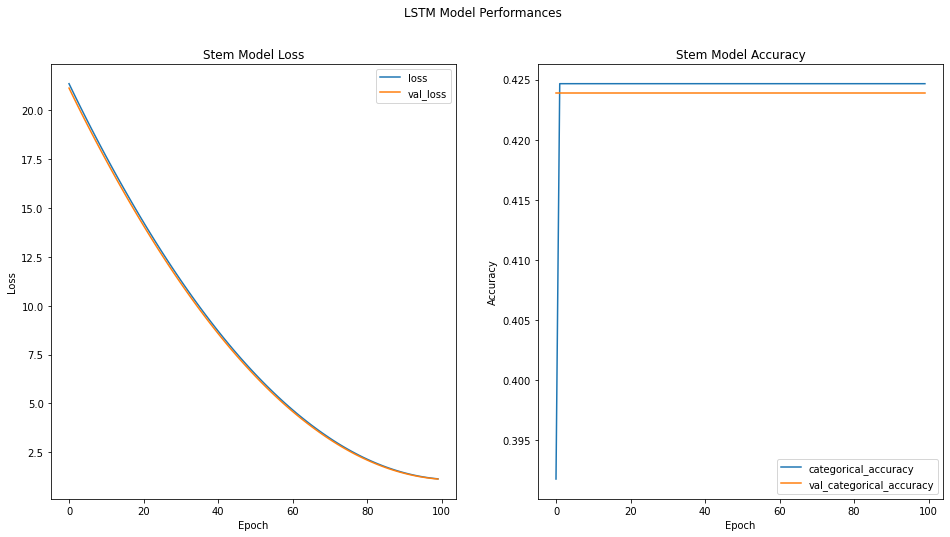

In [26]:
# Check Model Performances

metrics_model = pd.DataFrame(model_lstm.history)

fig_s, axes = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

metrics_model[['loss', 'val_loss']].plot(ylabel = 'Loss', xlabel = 'Epoch', title = 'Stem Model Loss', ax=axes[0])
metrics_model[['categorical_accuracy', 'val_categorical_accuracy']].plot(ylabel = 'Accuracy', xlabel = 'Epoch', title = 'Stem Model Accuracy', ax=axes[1])
fig_s.suptitle('LSTM Model Performances')

In [27]:
# Load pre-trained embeddings model

model = Sequential()
hub_url = "/kaggle/input/daily-stock-sentiment-analysis/tf2-preview_nnlm-id-dim50_1"
embed = hub.KerasLayer(hub_url)
embeddings = embed(["A long sentence.", "single-word", "http://example.com"])
print(embeddings.shape, embeddings.dtype)

(3, 50) <dtype: 'float32'>


In [28]:
# Define pre-trained model

hub_layer = hub.KerasLayer("/kaggle/input/daily-stock-sentiment-analysis/tf2-preview_nnlm-id-dim50_1", output_shape=[50],
                           input_shape=[], dtype=tf.string)

model = Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='AdaMax', metrics='categorical_accuracy')

callbacks = [
    # Stop training when a monitored metric has stopped improving
    EarlyStopping(
        monitor='val_loss', patience=20, min_delta=0.0001, mode='min', 
        restore_best_weights=True),
    # Reduce learning rate when a metric has stopped improving.
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, 
        # We believe ReduceLROnPlateau should have less patience than EarlyStopping
        patience=10, min_delta=0.0001, min_lr=0.001),
]

model_embed = model.fit(X_train,
                      train_labels,
                      callbacks=callbacks,
                      epochs=100,
                      validation_data=(X_val, val_labels))

Epoch 1/100
12/12 [==============================] - 1s 22ms/step - loss: 1.0711 - categorical_accuracy: 0.3918 - val_loss: 1.0561 - val_categorical_accuracy: 0.5000
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 1.0605 - categorical_accuracy: 0.4082 - val_loss: 1.0539 - val_categorical_accuracy: 0.4891
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 1.0540 - categorical_accuracy: 0.4082 - val_loss: 1.0519 - val_categorical_accuracy: 0.5000
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 1.0513 - categorical_accuracy: 0.3945 - val_loss: 1.0499 - val_categorical_accuracy: 0.5109
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 1.0467 - categorical_accuracy: 0.4438 - val_loss: 1.0482 - val_categorical_accuracy: 0.5217
Epoch 6/100
12/12 [==============================] - 0s 5ms/step - loss: 1.0368 - categorical_accuracy: 0.4603 - val_loss: 1.0465 - val_categorical_accuracy: 0.5326
Epoch 7/1

Text(0.5, 0.98, 'Pre-trained Model Performances')

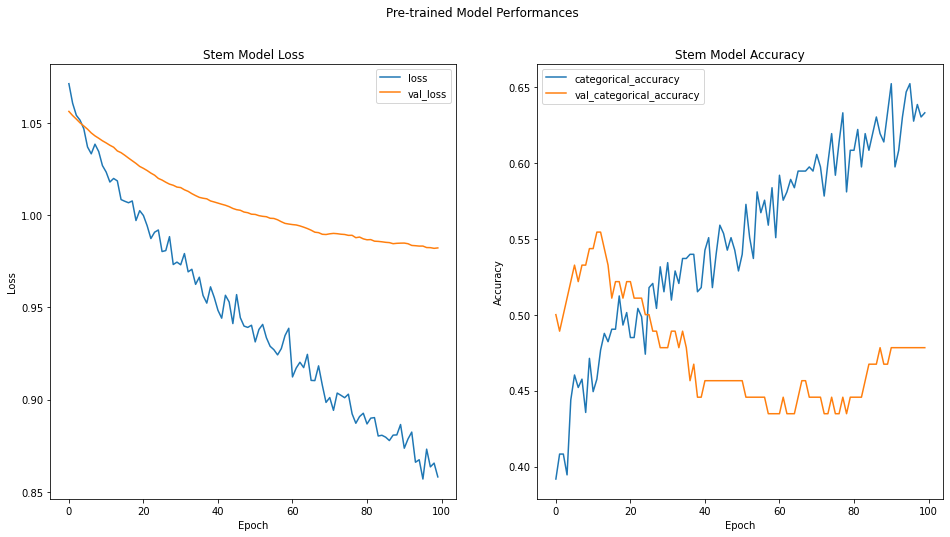

In [29]:
# Check pre-trained model perfomances

metrics_model = pd.DataFrame(model_embed.history)

fig_s, axes = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

metrics_model[['loss', 'val_loss']].plot(ylabel = 'Loss', xlabel = 'Epoch', title = 'Stem Model Loss', ax=axes[0])
metrics_model[['categorical_accuracy', 'val_categorical_accuracy']].plot(ylabel = 'Accuracy', xlabel = 'Epoch', title = 'Stem Model Accuracy', ax=axes[1])
fig_s.suptitle('Pre-trained Model Performances')

              precision    recall  f1-score   support

           0       0.47      0.92      0.62        49
           1       0.75      0.28      0.41        32
           2       0.71      0.15      0.24        34

    accuracy                           0.51       115
   macro avg       0.64      0.45      0.42       115
weighted avg       0.62      0.51      0.45       115



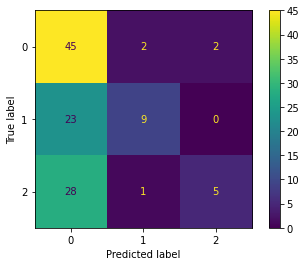

In [30]:
# Check pre-trained model performances against test set

y_pred_embed = model.predict(X_test)
y_pred_embed = np.where(y_pred_embed >=0.5, 1, 0)

# Converting prediction result into array
lst = np.array(y_pred_embed).tolist()
lst_val = []
for x in lst:
    lst_val.append(x.index(max(x)))
lst_val

cm_stem = confusion_matrix(y_test, lst_val)

print(classification_report(y_test, lst_val))
ConfusionMatrixDisplay(cm_stem).plot()

In [31]:
# Check pre-trained model scores

model_embed = pd.DataFrame(model_embed.history)

seq_2_best_epochs = np.argmin(model_embed['val_loss'])
print("epochs %d" % (seq_2_best_epochs))
print("categorical_accuracy %.2f" % 
      (model_embed.iloc[seq_2_best_epochs]['categorical_accuracy']))
print("val_categorical_accuracy %.2f" %
      (model_embed.iloc[seq_2_best_epochs]['val_categorical_accuracy']))
print("loss %.2f" %
      ((model_embed.iloc[seq_2_best_epochs]['loss'])))
print("val_loss %.2f" % 
      (model_embed.iloc[seq_2_best_epochs]['val_loss']))

epochs 98
categorical_accuracy 0.63
val_categorical_accuracy 0.48
loss 0.87
val_loss 0.98


In [32]:
# Define LSTM tuned model

model_imp = Sequential()
model_imp.add(text_vectorization)
model_imp.add(Embedding(input_dim = jumlah_voc,
                   output_dim = 300,
                   embeddings_initializer='uniform',
                   input_length = quantile))
model_imp.add(SpatialDropout1D(0.2))
model_imp.add(LSTM(128, dropout=0.2, kernel_initializer='glorot_uniform', kernel_regularizer='l2', return_sequences=True))
model_imp.add(LSTM(64))
model_imp.add(Dense(3, activation='softmax'))

model_imp.compile(loss='categorical_crossentropy', optimizer='Adam', metrics='categorical_accuracy')

callbacks = [
    # Stop training when a monitored metric has stopped improving
    EarlyStopping(
        monitor='val_loss', patience=20, min_delta=0.0001, mode='min', 
        restore_best_weights=True),
    # Reduce learning rate when a metric has stopped improving.
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, 
        # We believe ReduceLROnPlateau should have less patience than EarlyStopping
        patience=10, min_delta=0.0001, min_lr=0.001),
]

model_lstm_imp = model_imp.fit(X_train,
                      train_labels,
                      callbacks=callbacks,
                      epochs=100,
                      validation_data=(X_val, val_labels))

Epoch 1/100
12/12 [==============================] - 6s 148ms/step - loss: 4.2422 - categorical_accuracy: 0.3699 - val_loss: 3.5245 - val_categorical_accuracy: 0.4348
Epoch 2/100
12/12 [==============================] - 1s 59ms/step - loss: 3.0538 - categorical_accuracy: 0.4877 - val_loss: 2.6151 - val_categorical_accuracy: 0.3478
Epoch 3/100
12/12 [==============================] - 1s 58ms/step - loss: 2.1215 - categorical_accuracy: 0.5726 - val_loss: 2.0976 - val_categorical_accuracy: 0.5109
Epoch 4/100
12/12 [==============================] - 1s 58ms/step - loss: 1.4058 - categorical_accuracy: 0.7041 - val_loss: 1.8379 - val_categorical_accuracy: 0.4565
Epoch 5/100
12/12 [==============================] - 1s 57ms/step - loss: 0.9875 - categorical_accuracy: 0.7918 - val_loss: 1.8025 - val_categorical_accuracy: 0.4783
Epoch 6/100
12/12 [==============================] - 1s 58ms/step - loss: 0.6672 - categorical_accuracy: 0.8904 - val_loss: 1.9217 - val_categorical_accuracy: 0.4348
Epo

Text(0.5, 0.98, 'LSTM Tuned Performances')

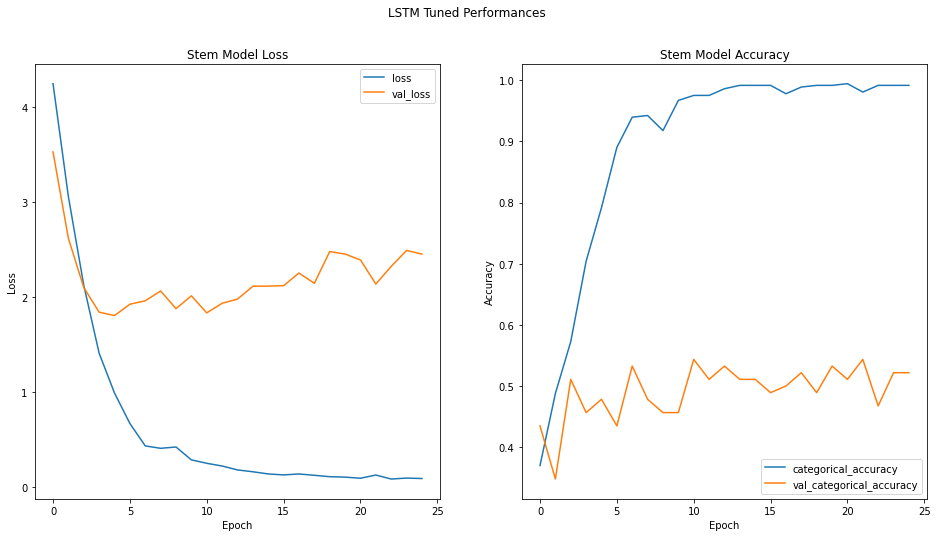

In [33]:
# Check tuned model performances

metrics_model_imp = pd.DataFrame(model_lstm_imp.history)

fig_s, axes = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

metrics_model_imp[['loss', 'val_loss']].plot(ylabel = 'Loss', xlabel = 'Epoch', title = 'Stem Model Loss', ax=axes[0])
metrics_model_imp[['categorical_accuracy', 'val_categorical_accuracy']].plot(ylabel = 'Accuracy', xlabel = 'Epoch', title = 'Stem Model Accuracy', ax=axes[1])
fig_s.suptitle('LSTM Tuned Performances')

In [34]:
# Define GRU model

model_gru = Sequential()
model_gru.add(text_vectorization)
model_gru.add(Embedding(input_dim = jumlah_voc,
                   output_dim = 128,
                   embeddings_initializer='uniform',
                   input_length = quantile))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.1))
model_gru.add(Dense(3, activation='softmax'))

model_gru.compile(loss='categorical_crossentropy', optimizer='Adam', metrics='categorical_accuracy')

callbacks = [
    # Stop training when a monitored metric has stopped improving
    EarlyStopping(
        monitor='val_loss', patience=20, min_delta=0.0001, mode='min', 
        restore_best_weights=True),
    # Reduce learning rate when a metric has stopped improving.
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, 
        # We believe ReduceLROnPlateau should have less patience than EarlyStopping
        patience=10, min_delta=0.0001, min_lr=0.001),
]

model_gru_hist = model_gru.fit(X_train,
                      train_labels,
                      callbacks=callbacks,
                      epochs=100,
                      validation_data=(X_val, val_labels))

Epoch 1/100
12/12 [==============================] - 6s 125ms/step - loss: 1.0912 - categorical_accuracy: 0.3918 - val_loss: 1.0789 - val_categorical_accuracy: 0.4239
Epoch 2/100
12/12 [==============================] - 1s 45ms/step - loss: 1.0647 - categorical_accuracy: 0.4301 - val_loss: 1.0828 - val_categorical_accuracy: 0.4239
Epoch 3/100
12/12 [==============================] - 1s 46ms/step - loss: 1.0412 - categorical_accuracy: 0.5260 - val_loss: 1.0888 - val_categorical_accuracy: 0.4239
Epoch 4/100
12/12 [==============================] - 1s 46ms/step - loss: 0.9972 - categorical_accuracy: 0.5479 - val_loss: 1.0988 - val_categorical_accuracy: 0.4022
Epoch 5/100
12/12 [==============================] - 1s 46ms/step - loss: 0.8708 - categorical_accuracy: 0.5890 - val_loss: 1.2271 - val_categorical_accuracy: 0.3913
Epoch 6/100
12/12 [==============================] - 1s 43ms/step - loss: 0.6268 - categorical_accuracy: 0.7151 - val_loss: 1.2154 - val_categorical_accuracy: 0.4783
Epo

Text(0.5, 0.98, 'GRU Model Performances')

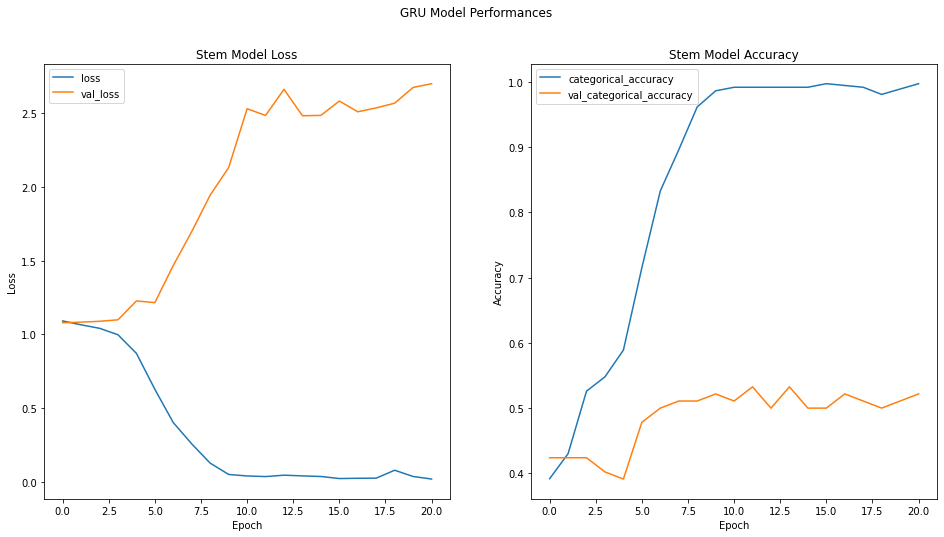

In [35]:
# Check GRU model performances

metrics_gru = pd.DataFrame(model_gru_hist.history)

fig_s, axes = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

metrics_gru[['loss', 'val_loss']].plot(ylabel = 'Loss', xlabel = 'Epoch', title = 'Stem Model Loss', ax=axes[0])
metrics_gru[['categorical_accuracy', 'val_categorical_accuracy']].plot(ylabel = 'Accuracy', xlabel = 'Epoch', title = 'Stem Model Accuracy', ax=axes[1])
fig_s.suptitle('GRU Model Performances')

              precision    recall  f1-score   support

           0       0.58      0.57      0.58        49
           1       0.49      0.56      0.52        32
           2       0.47      0.41      0.44        34

    accuracy                           0.52       115
   macro avg       0.51      0.52      0.51       115
weighted avg       0.52      0.52      0.52       115



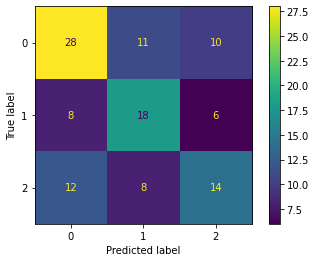

In [36]:
# Tuned model evaluation on test set

y_pred_lstm = model_imp.predict(X_test)
y_pred_lstm = np.where(y_pred_lstm >=0.5, 1, 0)

lst = np.array(y_pred_lstm).tolist()
lst_val = []
for x in lst:
    lst_val.append(x.index(max(x)))
lst_val

cm_stem = confusion_matrix(y_test, lst_val)

print(classification_report(y_test, lst_val))
ConfusionMatrixDisplay(cm_stem).plot()

In [37]:
# Check tuned model scores

model_imp_hist_df = pd.DataFrame(model_lstm_imp.history)

seq_2_best_epochs = np.argmin(model_imp_hist_df['val_loss'])
print("epochs %d" % (seq_2_best_epochs))
print("categorical_accuracy %.2f" % 
      (model_imp_hist_df.iloc[seq_2_best_epochs]['categorical_accuracy']))
print("val_categorical_accuracy %.2f" % 
      (model_imp_hist_df.iloc[seq_2_best_epochs]['val_categorical_accuracy']))
print("loss %.2f" %
      ((model_imp_hist_df.iloc[seq_2_best_epochs]['loss'])))
print("val_loss %.2f" % 
      (model_imp_hist_df.iloc[seq_2_best_epochs]['val_loss']))

epochs 4
categorical_accuracy 0.79
val_categorical_accuracy 0.48
loss 0.99
val_loss 1.80


# 7 - Model Saving

In [38]:
# Check selected model summary

model_imp.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 20)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 300)           835200    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 20, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 128)           219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 1,104,451
Trainable params: 1,104,451
Non-trainable params: 0
____________________________________________

In [39]:
# Freeze model parameters

model_imp.trainable = False
model_imp.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 20)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 300)           835200    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 20, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 128)           219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 1,104,451
Trainable params: 0
Non-trainable params: 1,104,451
____________________________________________

In [40]:
# Model savings

model_imp.save('model_lstm_imp_ver3')

2022-12-21 10:07:00.391886: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [41]:
# Check model scores

model_imp_df = pd.DataFrame(model_lstm_imp.history)

seq_2_best_epochs = np.argmin(model_imp_df['val_loss'])
print("epochs %d" % (seq_2_best_epochs))
print("categorical_accuracy %.2f" % 
      (model_imp_df.iloc[seq_2_best_epochs]['categorical_accuracy']))
print("val_categorical_accuracy %.2f" % 
      (model_imp_df.iloc[seq_2_best_epochs]['val_categorical_accuracy']))
print("loss %.2f" %
      ((model_imp_df.iloc[seq_2_best_epochs]['loss'])))
print("val_loss %.2f" % 
      (model_imp_df.iloc[seq_2_best_epochs]['val_loss']))

epochs 4
categorical_accuracy 0.79
val_categorical_accuracy 0.48
loss 0.99
val_loss 1.80


In [42]:
# Define engram functions

def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Text(0.5, 1.0, 'Positive Words')

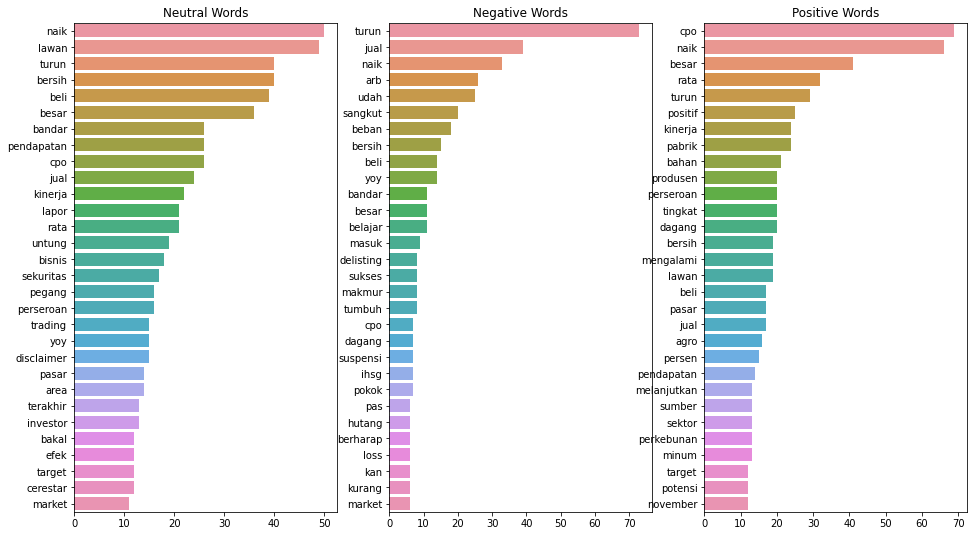

In [43]:
# Create unigram plot for most frequent words

plt.figure(figsize = (16,9))
plt.subplot(1,3,1)
kata_terbanyak = get_top_text_ngrams(df_fix['text_processed'].loc[df_fix['label_1']==0],30,1)
kata_terbanyak = dict(kata_terbanyak)
sns.barplot(x=list(kata_terbanyak.values()),y=list(kata_terbanyak.keys()))
plt.title('Neutral Words')                                                
plt.subplot(1,3,2)
kata_terbanyak = get_top_text_ngrams(df_fix['text_processed'].loc[df_fix['label_1']==1],30,1)
kata_terbanyak = dict(kata_terbanyak)
sns.barplot(x=list(kata_terbanyak.values()),y=list(kata_terbanyak.keys()))
plt.title('Negative Words')  
plt.subplot(1,3,3)
kata_terbanyak = get_top_text_ngrams(df_fix['text_processed'].loc[df_fix['label_1']==2],30,1)
kata_terbanyak = dict(kata_terbanyak)
sns.barplot(x=list(kata_terbanyak.values()),y=list(kata_terbanyak.keys()))
plt.title('Positive Words')  

In [44]:
# Define new vectorizer for ML models

model_vec = CountVectorizer()
model_vec.fit(X_train)
X_train_vec = model_vec.transform(X_train)
X_test_vec = model_vec.transform(X_test)
X_val_vec = model_vec.transform(X_val)

In [45]:
# Define KNN model

model_knn_count_vect_sw_stem = KNeighborsClassifier(n_neighbors=5)

model_knn_count_vect_sw_stem.fit(X_train_vec, y_train)

y_pred_test = model_knn_count_vect_sw_stem.predict(X_test_vec)

# Model Evaluation - Train Set

y_pred_train = model_knn_count_vect_sw_stem.predict(X_train_vec)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.47      0.94      0.63        49
           1       0.78      0.22      0.34        32
           2       0.38      0.09      0.14        34

    accuracy                           0.49       115
   macro avg       0.54      0.42      0.37       115
weighted avg       0.53      0.49      0.40       115



In [46]:
# Define SVM model

svc = SVC()
svc.fit(X_train_vec, y_train)

y_pred_train_svc = svc.predict(X_train_vec)
y_pred_test_svc = svc.predict(X_test_vec)

print(classification_report(y_test, y_pred_test_svc))

              precision    recall  f1-score   support

           0       0.46      0.86      0.60        49
           1       0.90      0.28      0.43        32
           2       0.50      0.21      0.29        34

    accuracy                           0.50       115
   macro avg       0.62      0.45      0.44       115
weighted avg       0.59      0.50      0.46       115



In [47]:
# Define Decision Tree model

DC = DecisionTreeClassifier()
DC.fit(X_train_vec, y_train)

y_pred_train = DC.predict(X_train_vec)
y_pred_test = DC.predict(X_test_vec)

recall_train = recall_score(y_pred_train,y_train,average='weighted')
recall_test = recall_score(y_pred_test,y_test,average='weighted')
precision_train = precision_score(y_pred_train,y_train,average='weighted')
precision_test = precision_score(y_pred_test,y_test,average='weighted')
f1_train = f1_score(y_pred_train,y_train,average='weighted')
f1_test = f1_score(y_pred_test,y_test,average='weighted')

print('Nilai Recall Train : ', recall_train)
print('Nilai Recall Test : ', recall_test)
print('Nilai Precision Train : ', precision_train)
print('Nilai Precision Test : ', precision_test)
print('Nilai F1 Train : ', f1_train)
print('Nilai F1 Test : ', f1_test)

print(classification_report(y_test, y_pred_test))

Nilai Recall Train :  0.9972602739726028
Nilai Recall Test :  0.5478260869565217
Nilai Precision Train :  0.9972854090737715
Nilai Precision Test :  0.5960909363745499
Nilai F1 Train :  0.9972621820011607
Nilai F1 Test :  0.558859019245306
              precision    recall  f1-score   support

           0       0.55      0.73      0.63        49
           1       0.62      0.41      0.49        32
           2       0.50      0.41      0.45        34

    accuracy                           0.55       115
   macro avg       0.55      0.52      0.52       115
weighted avg       0.55      0.55      0.54       115



In [48]:
# Define Random Forest model

rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train)

y_pred_train = rf.predict(X_train_vec)
y_pred_test= rf.predict(X_test_vec)

recall_train = recall_score(y_pred_train,y_train,average='weighted')
recall_test = recall_score(y_pred_test,y_test,average='weighted')
precision_train = precision_score(y_pred_train,y_train,average='weighted')
precision_test = precision_score(y_pred_test,y_test,average='weighted')
f1_train = f1_score(y_pred_train,y_train,average='weighted')
f1_test = f1_score(y_pred_test,y_test,average='weighted')

print('Nilai Recall Train : ', recall_train)
print('Nilai Recall Test : ', recall_test)
print('Nilai Precision Train : ', precision_train)
print('Nilai Precision Test : ', precision_test)
print('Nilai F1 Train : ', f1_train)
print('Nilai F1 Test : ', f1_test)

print(classification_report(y_test, y_pred_test))

Nilai Recall Train :  0.9972602739726028
Nilai Recall Test :  0.5478260869565217
Nilai Precision Train :  0.9972854090737715
Nilai Precision Test :  0.6760761913461036
Nilai F1 Train :  0.9972621820011607
Nilai F1 Test :  0.5763412909998487
              precision    recall  f1-score   support

           0       0.53      0.84      0.65        49
           1       0.68      0.41      0.51        32
           2       0.50      0.26      0.35        34

    accuracy                           0.55       115
   macro avg       0.57      0.50      0.50       115
weighted avg       0.56      0.55      0.52       115



In [49]:
# Transform train and test set to array for gaussian model

X_train_arr=X_train_vec.toarray()
X_test_arr=X_test_vec.toarray()

In [50]:
# Define Gaussian Naive Bayes model

gnb = GaussianNB()
gnb.fit(X_train_arr, y_train)

y_pred_train = gnb.predict(X_train_arr)
y_pred_test = gnb.predict(X_test_arr)

recall_train = recall_score(y_pred_train,y_train,average='weighted')
recall_test = recall_score(y_pred_test,y_test,average='weighted')
precision_train = precision_score(y_pred_train,y_train,average='weighted')
precision_test = precision_score(y_pred_test,y_test,average='weighted')
f1_train = f1_score(y_pred_train,y_train,average='weighted')
f1_test = f1_score(y_pred_test,y_test,average='weighted')

print('Nilai Recall Train : ', recall_train)
print('Nilai Recall Test : ', recall_test)
print('Nilai Precision Train : ', precision_train)
print('Nilai Precision Test : ', precision_test)
print('Nilai F1 Train : ', f1_train)
print('Nilai F1 Test : ', f1_test)

print(classification_report(y_test, y_pred_test))

Nilai Recall Train :  0.9315068493150684
Nilai Recall Test :  0.5565217391304348
Nilai Precision Train :  0.9393832170497067
Nilai Precision Test :  0.5702783287227935
Nilai F1 Train :  0.9319175279281369
Nilai F1 Test :  0.556983074674204
              precision    recall  f1-score   support

           0       0.65      0.49      0.56        49
           1       0.56      0.69      0.62        32
           2       0.46      0.53      0.49        34

    accuracy                           0.56       115
   macro avg       0.56      0.57      0.56       115
weighted avg       0.57      0.56      0.56       115



In [51]:
# Define Complement Naive Bayes

cnb = ComplementNB()
cnb.fit(X_train_vec, y_train)

y_pred_train = cnb.predict(X_train_vec)
y_pred_test = cnb.predict(X_test_vec)

recall_train = recall_score(y_pred_train,y_train,average='weighted')
recall_test = recall_score(y_pred_test,y_test,average='weighted')
precision_train = precision_score(y_pred_train,y_train,average='weighted')
precision_test = precision_score(y_pred_test,y_test,average='weighted')
f1_train = f1_score(y_pred_train,y_train,average='weighted')
f1_test = f1_score(y_pred_test,y_test,average='weighted')

print('Nilai Recall Train : ', recall_train)
print('Nilai Recall Test : ', recall_test)
print('Nilai Precision Train : ', precision_train)
print('Nilai Precision Test : ', precision_test)
print('Nilai F1 Train : ', f1_train)
print('Nilai F1 Test : ', f1_test)

print(classification_report(y_test, y_pred_test))

Nilai Recall Train :  0.9260273972602739
Nilai Recall Test :  0.5565217391304348
Nilai Precision Train :  0.9276959922759537
Nilai Precision Test :  0.5559469439949892
Nilai F1 Train :  0.9259476041233394
Nilai F1 Test :  0.5557670192290657
              precision    recall  f1-score   support

           0       0.60      0.59      0.60        49
           1       0.57      0.53      0.55        32
           2       0.49      0.53      0.51        34

    accuracy                           0.56       115
   macro avg       0.55      0.55      0.55       115
weighted avg       0.56      0.56      0.56       115



In [52]:
# Tuning Complement Naive Bayes model

grid_cnb = GridSearchCV(
        estimator=cnb,
        scoring='f1_weighted',
        param_grid={
            'alpha': np.logspace(0,1, num=100),
            'norm' : [True,False]
        },
        return_train_score=True,
        n_jobs=-1
    )
grid_cnb.fit(X=X_train_arr, y=y_train)

print("params", grid_cnb.best_params_)
print("score", grid_cnb.best_score_)

params {'alpha': 6.734150657750823, 'norm': True}
score 0.5477088312868992


In [53]:
# Get best estimator

best = grid_cnb.best_estimator_

Nilai Recall Train    :  0.8958904109589041
Nilai Recall Test     :  0.6173913043478261
Nilai Precision Train :  0.8969310619475882
Nilai Precision Test  :  0.6210560311080955
Nilai F1 Train        :  0.8959587787610672
Nilai F1 Test         :  0.6157861626969178

Classification Report Naive Bayes

              precision    recall  f1-score   support

           0       0.64      0.65      0.65        49
           1       0.72      0.56      0.63        32
           2       0.53      0.62      0.57        34

    accuracy                           0.62       115
   macro avg       0.63      0.61      0.62       115
weighted avg       0.63      0.62      0.62       115




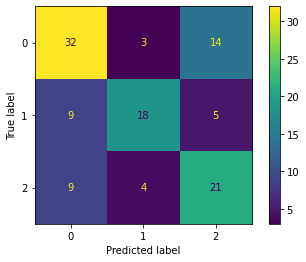

In [54]:
# Tuned Model Prediction

y_pred_train = best.predict(X_train_vec)
y_pred_test = best.predict(X_test_vec)

recall_train = recall_score(y_pred_train,y_train,average='weighted')
recall_test = recall_score(y_pred_test,y_test,average='weighted')
precision_train = precision_score(y_pred_train,y_train,average='weighted')
precision_test = precision_score(y_pred_test,y_test,average='weighted')
f1_train = f1_score(y_pred_train,y_train,average='weighted')
f1_test = f1_score(y_pred_test,y_test,average='weighted')

print('Nilai Recall Train    : ', recall_train)
print('Nilai Recall Test     : ', recall_test)
print('Nilai Precision Train : ', precision_train)
print('Nilai Precision Test  : ', precision_test)
print('Nilai F1 Train        : ', f1_train)
print('Nilai F1 Test         : ', f1_test)
print('')
print('Classification Report Naive Bayes')
print('')
print(classification_report(y_test, y_pred_test))
print('')
cm_stem = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(cm_stem).plot()

In [55]:
# Check base model score

y_pred_train = cnb.predict(X_train_vec)
y_pred_test = cnb.predict(X_test_vec)

recall_train = recall_score(y_pred_train,y_train,average='weighted')
recall_test = recall_score(y_pred_test,y_test,average='weighted')
precision_train = precision_score(y_pred_train,y_train,average='weighted')
precision_test = precision_score(y_pred_test,y_test,average='weighted')
f1_train = f1_score(y_pred_train,y_train,average='weighted')
f1_test = f1_score(y_pred_test,y_test,average='weighted')

print('Nilai Recall Train : ', recall_train)
print('Nilai Recall Test : ', recall_test)
print('Nilai Precision Train : ', precision_train)
print('Nilai Precision Test : ', precision_test)
print('Nilai F1 Train : ', f1_train)
print('Nilai F1 Test : ', f1_test)

print(classification_report(y_test, y_pred_test))

Nilai Recall Train :  0.9260273972602739
Nilai Recall Test :  0.5565217391304348
Nilai Precision Train :  0.9276959922759537
Nilai Precision Test :  0.5559469439949892
Nilai F1 Train :  0.9259476041233394
Nilai F1 Test :  0.5557670192290657
              precision    recall  f1-score   support

           0       0.60      0.59      0.60        49
           1       0.57      0.53      0.55        32
           2       0.49      0.53      0.51        34

    accuracy                           0.56       115
   macro avg       0.55      0.55      0.55       115
weighted avg       0.56      0.56      0.56       115



In [56]:
# Saving tuned Naive Bayes Model

with open('/kaggle/working/vectorizer_sentiment.pkl', 'wb') as file_1:
    joblib.dump(model_vec, file_1)
    
with open('/kaggle/working/model_sentiment.pkl', 'wb') as file_2:
     joblib.dump(grid_cnb, file_2)
    
with open('/kaggle/working/slangwords_sentiment.txt', 'wt') as file_3:
    for word in slangwords:
        file_3.write(f'{word}:{slangwords.get(word)}\n')
        
with open('/kaggle/working/stopwords_sentiment.txt', 'wt') as file_4:
    for word in stopwords:
        file_4.write(f'{word}\n')


Text(0.5, 1.0, 'Positive Words')

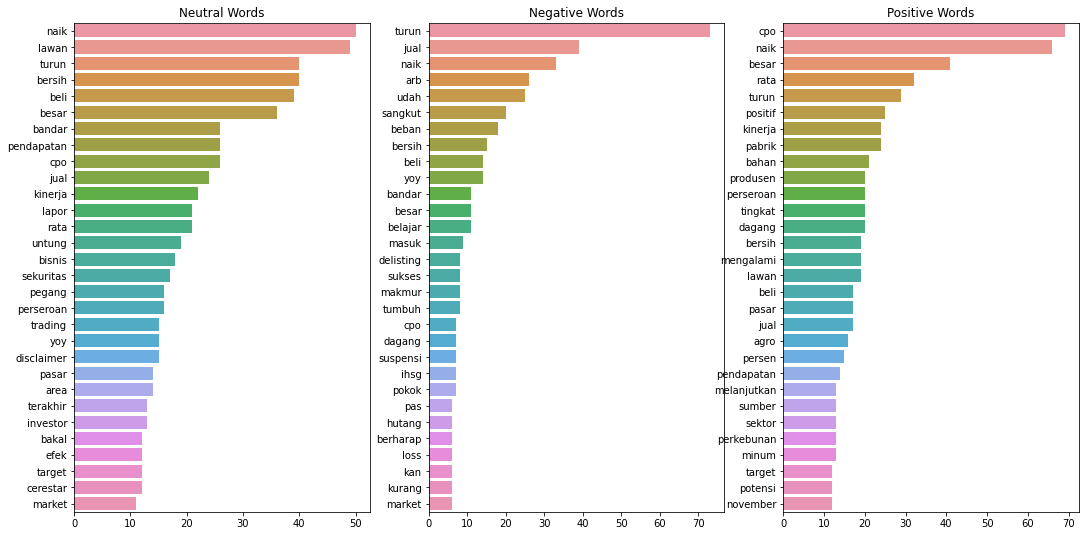

In [59]:
# Create unigram to see the most frequent words from each labels

plt.figure(figsize = (18,9))
plt.subplot(1,3,1)
kata_terbanyak1 = get_top_text_ngrams(df_fix['text_processed'].loc[df_fix['label_1']==0],30,1)
kata_terbanyak1 = dict(kata_terbanyak1)
sns.barplot(x=list(kata_terbanyak1.values()),y=list(kata_terbanyak1.keys()))
plt.title('Neutral Words')                                                
plt.subplot(1,3,2)
kata_terbanyak2 = get_top_text_ngrams(df_fix['text_processed'].loc[df_fix['label_1']==1],30,1)
kata_terbanyak2 = dict(kata_terbanyak2)
sns.barplot(x=list(kata_terbanyak2.values()),y=list(kata_terbanyak2.keys()))
plt.title('Negative Words')  
plt.subplot(1,3,3)
kata_terbanyak3 = get_top_text_ngrams(df_fix['text_processed'].loc[df_fix['label_1']==2],30,1)
kata_terbanyak3 = dict(kata_terbanyak3)
sns.barplot(x=list(kata_terbanyak3.values()),y=list(kata_terbanyak3.keys()))
plt.title('Positive Words')  

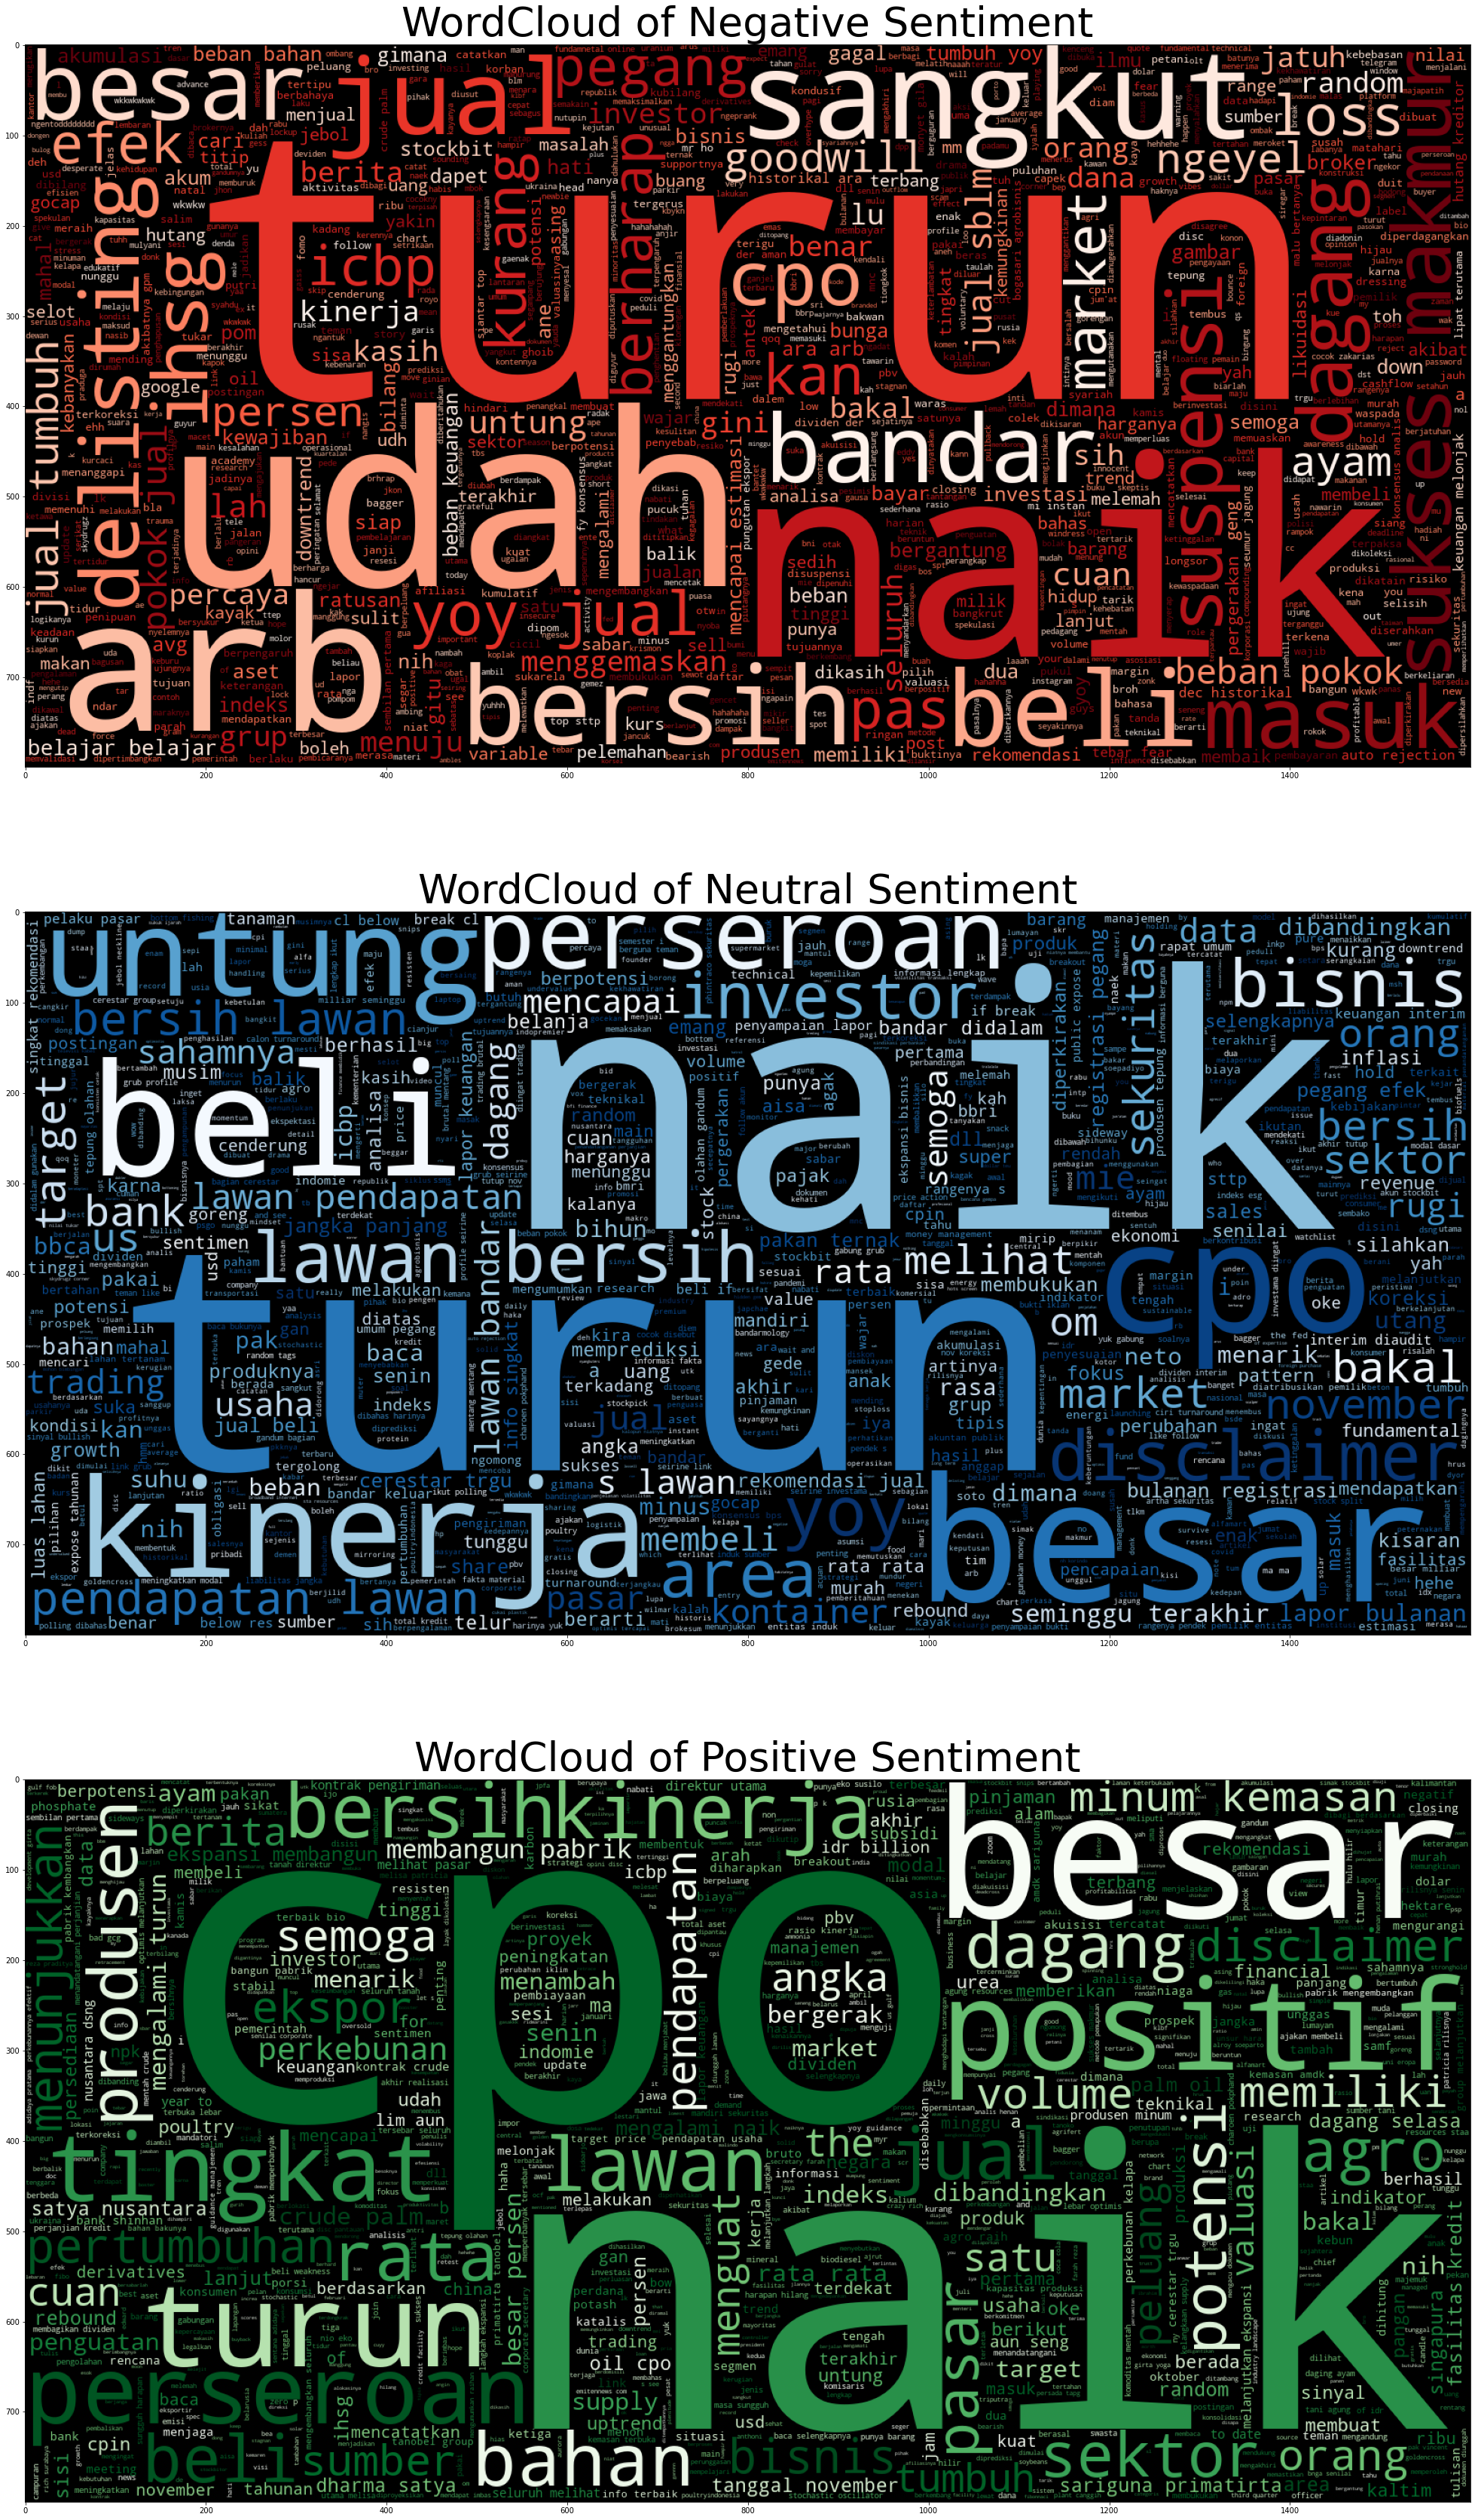

In [58]:
# Create wordcloud

fig, ax = plt.subplots(3, 1,figsize = (60, 60))
wc1 = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = stopwords, colormap='Reds').generate(" ".join(df_fix[df_fix.label_1 == 1].text_processed))
ax[0].set_title('WordCloud of Negative Sentiment',fontsize=54)
ax[0].imshow(wc1)
wc2 = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = stopwords, colormap='Blues').generate(" ".join(df_fix[df_fix.label_1 == 0].text_processed))
ax[1].set_title('WordCloud of Neutral Sentiment',fontsize=54)
ax[1].imshow(wc2)
wc3 = WordCloud(max_words = 1000, width = 1600 , height = 800 , stopwords = stopwords, colormap='Greens').generate(" ".join(df_fix[df_fix.label_1 == 2].text_processed))
ax[2].set_title('WordCloud of Positive Sentiment',fontsize=54)
ax[2].imshow(wc3)
plt.show()
